<a href="https://colab.research.google.com/github/erYash15/StackOverflow-Tag-prediction/blob/master/facebook_recruiting_iii_keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting the google drive to Google colab Notebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Step 1** — Get the API key from your account
Visit www.kaggle.com ⇨ login ⇨ My Account ⇨ Create New API Token
The “kaggle.json” file will be auto downloaded.

**Step 2** — Upload the kaggle.json file
Use these code snippets in Google Colab for the task:

In [0]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eryash15","key":"4d3c754d226d7fba028ded4615217df0"}'}

The below will create the necessary folder path.

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


**Step 3** — Download the required dataset
Simply download the required dataset with the syntax:

In [0]:
!kaggle competitions download -c facebook-recruiting-iii-keyword-extraction -p /content/gdrive/My\ Drive/kaggle

100% 2.18G/2.19G [00:27<00:00, 98.0MB/s]
100% 2.19G/2.19G [00:27<00:00, 84.3MB/s]
100% 4.81M/4.81M [00:00<00:00, 41.5MB/s]

 99% 718M/725M [00:09<00:00, 86.0MB/s]
100% 725M/725M [00:09<00:00, 83.1MB/s]


**Step 4** — Unzip

*For dataset with multiple zip files like the example, I tend to change directory to the designated folder and unzip them one by one.*

!unzip -q file[.zip] -d [exdir]

-q suppress the printing of the file names being extracted

-d [exdir] optional directory to which to extract files *italicized text*

In [0]:
import os
os.chdir('/content/gdrive/My Drive/kaggle')  #change dir
!unzip Train.zip  #unzip data
!unzip Test.zip  #unzip data
!unzip SampleSubmission.csv.zip

Archive:  Train.zip
  inflating: Train.csv               
Archive:  Test.zip
  inflating: Test.csv                
Archive:  SampleSubmission.csv.zip
  inflating: SampleSubmission.csv    


### **Import Libraries**

In [0]:
%matplotlib inline

import pandas as pd
import os
import datetime
import csv
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

## **Data Cleaning** - Stage 1

In [0]:
train_df = pd.read_csv('/content/gdrive/My Drive/kaggle/Train.csv')

In [3]:
print("Length of Raw input Train data", len(train_df))

Length of Raw input Train data 6034195


In [4]:
#Null Data Field
for c in train_df.columns:   
    print("Number of Null Cells in ---",c,"----are ",train_df[c].isnull().sum())

Number of Null Cells in --- Id ----are  0
Number of Null Cells in --- Title ----are  0
Number of Null Cells in --- Body ----are  0
Number of Null Cells in --- Tags ----are  8


In [0]:
#Remove Duplicates and field with Null Values
train_df.drop_duplicates(subset = ['Title','Body','Tags'], keep = 'first', inplace = True)
train_df.dropna(axis = 'index', how =  'any', inplace = True)

In [6]:
print("Length of Raw input Train data", len(train_df))

Length of Raw input Train data 4206307


Add tag_count coloumn in train_df

In [0]:
tags_count = []
for tags in train_df.Tags:
    tags_count.append(len(tags.split(" ")))
train_df['Tags_count'] = tags_count
del tags_count 

In [9]:
train_df.head()

,Id,Title,Body,Tags,Tags_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


Saving the train_df file in Google Drive.

In [11]:
train_df.to_csv("/content/gdrive/My Drive/kaggle/train_df.csv")
print("train_df saved to google drive.")

train_df saved to google drive.


## **Analysis of Tags**

In [0]:
#making spare matrix of tags
cv = CountVectorizer(tokenizer = lambda x: x.split()) 
# if we don't use tokenizer only numeric and albhabet will ignore .-, etc.
# and igonre the word with 1 letter.
tag_mtx = cv.fit_transform(train_df['Tags'])

In [13]:
print("Number of data points :", tag_mtx.shape[0])#rows
print("Number of unique tags :", tag_mtx.shape[1])#columns

Number of data points : 4206307
Number of unique tags : 42048


freq_dict contains all the tags and its frequency.

In [0]:
all_unique_tags = cv.get_feature_names()
freq = tag_mtx.sum(axis = 0).A1
#.A1 convert everyting to 1-D
freq_dict = dict(zip(all_unique_tags,freq))

Saving freq_dict in Google Drive and then converting it to pandas dataframe because for converting dictionary directly to pandas dataframe we have to convert values in list form and to avoid we first create .csv file. 

In [67]:
#Saving this dictionary to csv files.
with open('/content/gdrive/My Drive/kaggle/tag_freq_dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in freq_dict.items():
        writer.writerow([key, value])

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [75]:
tag_df = pd.read_csv('/content/gdrive/My Drive/kaggle/tag_freq_dict.csv', names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


Sorting the tag_df in the decending order

In [0]:
tag_df.sort_values(['Counts'], inplace = True, ascending = False)

Plot the Distribution of Frequency of Tags

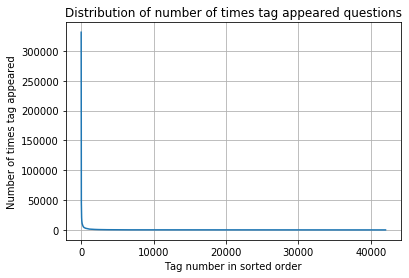

In [89]:
plt.plot(tag_df['Counts'].values)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number in sorted order")
plt.ylabel("Number of times tag appeared")
plt.show()

In [0]:
|